# Use Case 2 - Part 1: Using ulmo to explore USGS NWIS and CUAHSI HIS Data

- [Emilio Mayorga](https://github.com/emiliom), University of Washington
- [WaterHackWeek](https://waterhackweek.github.io/) Cyberseminar
- 2019-2-7
- **Re-ran successfully by Emilio on 2/26/2020 using his `whwtimeseries_cso.yml` conda env file**

In [1]:
%matplotlib inline

import pytz
import requests
import matplotlib.pyplot as plt
import pandas as pd
import folium

import ulmo
from ulmo.util import convert_datetime

# Request and explore NWIS sites in a HUC8 subbasin

Upper Little Tennessee HUC8 Subbasin 06010202. See [an interactive map on our GitHub repository.](https://github.com/waterhackweek/tsdata_access/blob/master/UpperLittleTennessee_HUC-8Subbasin_ID06010202.geojson)

In [2]:
HUC8code = '06010202'

## Issue the `ulmo nwis.get_sites` request, then cleanup and examine the results

In [3]:
nwis_sites = ulmo.usgs.nwis.get_sites(huc=HUC8code, service=None)

making request for sites: http://waterservices.usgs.gov/nwis/dv/
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&hucs=06010202
making request for sites: http://waterservices.usgs.gov/nwis/iv/
processing data from request: https://waterservices.usgs.gov/nwis/iv/?format=waterml&hucs=06010202


What does the response look like?

In [4]:
type(nwis_sites), len(nwis_sites)

(dict, 21)

In [5]:
nwis_sites.keys()

dict_keys(['03500000', '0350011450', '03500240', '03500500', '0350056050', '03501000', '03501500', '03501975', '03502500', '03503000', '03503500', '03504000', '03505500', '03505550', '03506500', '03507000', '03513500', '03514000', '350413083130045', '350557083325845', '351205083213545'])

It's a Python dictionary of sites. Let's examine one of the sites.

In [6]:
site_code = '03501500'

In [7]:
nwis_sites[site_code]

{'code': '03501500',
 'name': 'LITTLE TENNESSEE R AT FRANKLIN, NC',
 'network': 'NWIS',
 'agency': 'USGS',
 'location': {'latitude': '35.18592846',
  'longitude': '-83.3712647',
  'srs': 'EPSG:4326'},
 'timezone_info': {'uses_dst': True,
  'dst_tz': {'abbreviation': 'EDT', 'offset': '-04:00'},
  'default_tz': {'abbreviation': 'EST', 'offset': '-05:00'}},
 'county': '37113',
 'huc': '06010202',
 'site_type': 'ST',
 'state_code': '37'}

One thing it doesn't tell us is what parameters are measured at the site. Too bad.

In [8]:
# pull out lat & lon from the nested dictionary
for k, v in nwis_sites.items():
    v['longitude'] = v['location']['longitude']
    v['latitude'] = v['location']['latitude']

In [9]:
nwis_sites_df = pd.DataFrame(nwis_sites)
nwis_sites_df.head()

,03500000,0350011450,03500240,03500500,0350056050,03501000,03501500,03501975,03502500,03503000,...,03504000,03505500,03505550,03506500,03507000,03513500,03514000,350413083130045,350557083325845,351205083213545
agency,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,...,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS
code,03500000,0350011450,03500240,03500500,0350056050,03501000,03501500,03501975,03502500,03503000,...,03504000,03505500,03505550,03506500,03507000,03513500,03514000,350413083130045,350557083325845,351205083213545
county,37113,37113,37113,37113,37113,37113,37113,37113,37113,37173,...,37113,37173,37173,37173,37173,37173,37173,37113,37113,37113
huc,06010202,06010202,06010202,06010202,06010202,06010202,06010202,06010202,06010202,06010202,...,06010202,06010202,06010202,06010202,06010202,06010202,06010202,06010202,06010202,06010202
latitude,35.15,35.15776944,35.15888889,35.07064737,35.0761111,35.166484,35.18592846,35.2328611,35.2784285,35.33638889,...,35.1275,35.29870237,35.305,35.37564868,35.4084267,35.48481705,35.4773122,35.07027778,35.09916667,35.2


In [10]:
# Let's flip (transpose) the dataframe, so each row is a site
nwis_sites_df = nwis_sites_df.T
nwis_sites_df.head(2)

,agency,code,county,huc,latitude,location,longitude,name,network,site_type,state_code,timezone_info
03500000,USGS,03500000,37113,06010202,35.15,"{'latitude': '35.15', 'longitude': '-83.379722...",-83.3797222,"LITTLE TENNESSEE RIVER NEAR PRENTISS, NC",NWIS,ST,37,"{'uses_dst': True, 'dst_tz': {'abbreviation': ..."
0350011450,USGS,0350011450,37113,06010202,35.15776944,"{'latitude': '35.15776944', 'longitude': '-83....",-83.4243694,"CARTOOGECHAYE CREEK AT SR 1148 NEAR FRANKLIN, NC",NWIS,ST,37,"{'uses_dst': True, 'dst_tz': {'abbreviation': ..."


In [11]:
# Final cleanups, improvements
nwis_sites_df['latitude'] = nwis_sites_df['latitude'].astype(float)
nwis_sites_df['longitude'] = nwis_sites_df['longitude'].astype(float)
nwis_sites_df.drop(columns=['location', 'timezone_info'], inplace=True)
nwis_sites_df.head(2)

,agency,code,county,huc,latitude,longitude,name,network,site_type,state_code
03500000,USGS,03500000,37113,06010202,35.150000,-83.379722,"LITTLE TENNESSEE RIVER NEAR PRENTISS, NC",NWIS,ST,37
0350011450,USGS,0350011450,37113,06010202,35.157769,-83.424369,"CARTOOGECHAYE CREEK AT SR 1148 NEAR FRANKLIN, NC",NWIS,ST,37


*What's that "site_type"?* Summarize all values

In [12]:
nwis_sites_df['site_type'].value_counts()

ST    18
AT     3
Name: site_type, dtype: int64

Site type codes are defined at http://help.waterdata.usgs.gov/site_tp_cd. For our purposes:
 - ST: Stream
 - AT: Atmosphere
 
We could also have issued the `nwis.get_sites` query by passing a `site_type` value or list, like this:
```python
nwis_sits = ulmo.usgs.nwis.get_sites(huc=HUC8code, site_type=['ST'], service=None)
```

## Let's map the sites on an interactive map, with Folium
Colored by site type.

In [13]:
m = folium.Map(tiles='Stamen terrain')

for idx, row in nwis_sites_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                  icon=folium.Icon(color='blue' if row['site_type'] == 'ST' else 'gray'),
                  popup="<b>{0}</b> {1}. Site type: {2}. {3}".format(
                      row['code'], row['name'], row['site_type'], row['network'])
                 ).add_to(m)
    
# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m

The previous use case notebook from Yifan illustrated how to pull the time series data from nwis using ulmo, by specifying the site code and parameter code.

# How does this NWIS view compare to what we can find on that HUC8 using the **ModelMyWatershed App?**
Let's go there and do some querying and browsing. https://modelmywatershed.org. We can navigate to the specific HUC8, or upload a GeoJSON spatial file for the HUC8, generated in advance.

Also, I wonder what data are available near the **Coweeta** LTER station ...

# Use `ulmo.cuahsi.wof` to pull time series data from a nearby site on CUAHSI HIS

For examples of CUAHSI HIS catalog "spatial querying" (based on a bounding box) analogous to the NWIS spatial querying we've presented, go to [this CUAHSI resource on HydroShare](https://www.hydroshare.org/resource/c184323fc95c4c3e85c663f519b47084/). It includes a Jupyter notebook and a presentation on the CUAHI HIS Central API.

## Explore relevant sites on **HydroClient**

I want to find a site "nearby", even if it's not in that HUC8, that meets these criteria:
- Has dissolved oxygen
- Is from a source other than the big federal agencies

To do this, let's go to HydroClient. http://data.cuahsi.org. There, we can also visualize the time series using the HydroShare TimeSeries Viewer App, or download the data.

## Back to the code, to pull in the site's time series data
I got `networkcd`, `sitecd` and `varcd` from the HydroClient results.

In [14]:
# http://hiscentral.cuahsi.org/pub_network.aspx?n=5639
networkcd = 'ORSANCO_HAB'

# The "WSDL URL" (CUAHSI WaterOneFlow web service endpoint)
wsdlurl = "http://hydroportal.cuahsi.org/{}/cuahsi_1_1.asmx?WSDL".format(networkcd)

In [15]:
sitecd = 'RCByrd'

## But first let's explore site information (metadata, data availability)

In [16]:
siteinfo = ulmo.cuahsi.wof.get_site_info(wsdlurl, "{}:{}".format(networkcd, sitecd))

In [17]:
siteinfo.keys()

dict_keys(['code', 'name', 'network', 'location', 'series'])

The response is in **CUAHSI WaterML 1.1 format**, transformed by `ulmo` from the original XML into a Python dictionary for easier access.

In [18]:
siteinfo

{'code': 'RCByrd',
 'name': 'Robert C. Byrd Locks and Dam',
 'network': 'ORSANCO_HAB',
 'location': {'latitude': '38.685029',
  'longitude': '-82.183691',
  'srs': 'EPSG:4269'},
 'series': {'ORSANCO_HAB:Bat_30': {'variable': {'value_type': 'Field Observation',
    'data_type': 'Regular Sampling',
    'general_category': 'Water Quality',
    'sample_medium': 'Surface water',
    'no_data_value': '-9999',
    'speciation': 'Not Applicable',
    'code': 'Bat_30',
    'id': '59',
    'name': 'Battery voltage',
    'vocabulary': 'ORSANCO_HAB',
    'time': {'is_regular': True,
     'interval': '30',
     'units': {'abbreviation': 'min',
      'code': '102',
      'name': 'minute',
      'type': 'Time'}},
    'units': {'abbreviation': 'V',
     'code': '168',
     'name': 'volts',
     'type': 'Potential Difference'}},
   '{http://www.cuahsi.org/water_ml/1.1/}method': {'method_id': '81',
    'method_description': 'Data was collected in-situ at regular intervals by datasonde'},
   '{http://www

## Request, parse and plot the time series

In [19]:
varcd = "ORSANCO_HAB:ODO_30"

In [20]:
siteinfo['series'][varcd]

{'variable': {'value_type': 'Field Observation',
  'data_type': 'Regular Sampling',
  'general_category': 'Water Quality',
  'sample_medium': 'Surface water',
  'no_data_value': '-9999',
  'speciation': 'O2',
  'code': 'ODO_30',
  'id': '65',
  'name': 'Oxygen, dissolved',
  'vocabulary': 'ORSANCO_HAB',
  'time': {'is_regular': True,
   'interval': '30',
   'units': {'abbreviation': 'min',
    'code': '102',
    'name': 'minute',
    'type': 'Time'}},
  'units': {'abbreviation': 'mg/L',
   'code': '199',
   'name': 'milligrams per liter',
   'type': 'Concentration'}},
 '{http://www.cuahsi.org/water_ml/1.1/}method': {'method_id': '81',
  'method_description': 'Data was collected in-situ at regular intervals by datasonde'},
 '{http://www.cuahsi.org/water_ml/1.1/}source': {'source_id': '53',
  'organization': 'Marshall College ',
  'source_description': 'Marshall College',
  'citation': 'Unknown'},
 '{http://www.cuahsi.org/water_ml/1.1/}quality_control_level': {'quality_control_level_id':

In [21]:
time_interval = siteinfo['series'][varcd]['{http://www.cuahsi.org/water_ml/1.1/}variable_time_interval']
time_interval

{'variable_time_interval_type': 'TimeIntervalType',
 'begin_date_time': '2017-07-27T12:00:00',
 'end_date_time': '2017-09-05T12:00:00',
 'begin_date_time_utc': '2017-07-27T12:00:00',
 'end_date_time_utc': '2017-09-05T12:00:00'}

In [22]:
site_tsval = ulmo.cuahsi.wof.get_values(wsdlurl, "{}:{}".format(networkcd, sitecd), varcd,
                                        start=time_interval['begin_date_time_utc'], 
                                        end=time_interval['end_date_time_utc'])

In [23]:
site_tsval.keys()

dict_keys(['site', 'variable', 'values', 'censor_codes', 'methods', 'quality_control_levels', 'sources'])

In [24]:
def site_series_values_to_df(series_values, variable_name):
    # Create a clean timeseries list of (dt,val) tuples
    tsdt_tuplst = [(convert_datetime(valdict['datetime']).replace(tzinfo=pytz.utc), 
                    float(valdict['value']))
                   for valdict in series_values['values']]
    
    dt, val = zip(*tsdt_tuplst)
    ts_df = pd.DataFrame({'time':dt, variable_name:val})
    ts_df.set_index('time', inplace=True)
    ts_df.sort_index(ascending=True, inplace=True)
    return ts_df

In [25]:
ts_df = site_series_values_to_df(site_tsval, varcd)

In [26]:
ts_df.tail()

,ORSANCO_HAB:ODO_30
time,
2017-09-05 10:00:00+00:00,5.23
2017-09-05 10:30:00+00:00,5.27
2017-09-05 11:00:00+00:00,5.22
2017-09-05 11:30:00+00:00,5.29
2017-09-05 12:00:00+00:00,5.40


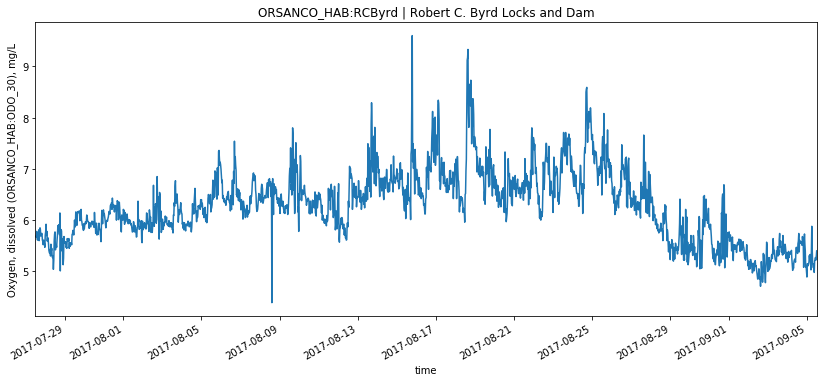

In [27]:
fig, ax = plt.subplots(figsize=(14, 6))
varlabel = ts_df.columns[0]
ts_df[varlabel].plot(style='-', ax=ax)

sitevariable = siteinfo['series'][varcd]['variable']
ax.set_ylabel("{} ({}), {}".format(sitevariable['name'], varlabel, sitevariable['units']['abbreviation']))
ax.set_title("{}:{} | {}".format(networkcd, sitecd, siteinfo['name']));